# Biodiversity

## Introduction
The goal of this project is to analyse the biodiversity datasets from National Parks Service. 

This project will analyze, prepare, plot data and seek to explain the findings from the analysis.

**Data sources:**
Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).

In [7]:
# Importing modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loading the data sets

## Observations
Observations.csv contains information about sightings of different species from the past 7 days. The dataset has three columns:
* scientific_name: The scientific name of the species
* park_name: The name of the park
* observations: The number of observations in the past 7 days

In [8]:
obs = pd.read_csv('observations.csv')
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Species
Species.csv contains information about the specific species in the national parks. The dataset has four columns:
* category: The category a specific species (e.g. mammal, bird, fish)
* scientific_name: The scientific name of a specific species
* common_names: The common name of a specific species
* conservation_status: A label for the risk of extinction

In [3]:
species = pd.read_csv('species_info.csv')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


# Exploring the datasets

I will check the dimentions if the datasets to get a sence of how many observations they contain.

In [10]:
print(f"species shape: {species.shape}")
print(f"observations shape: {obs.shape}")

species shape: (5824, 4)
observations shape: (23296, 3)


Taking a further look at the species dataset's category cloumns

In [14]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

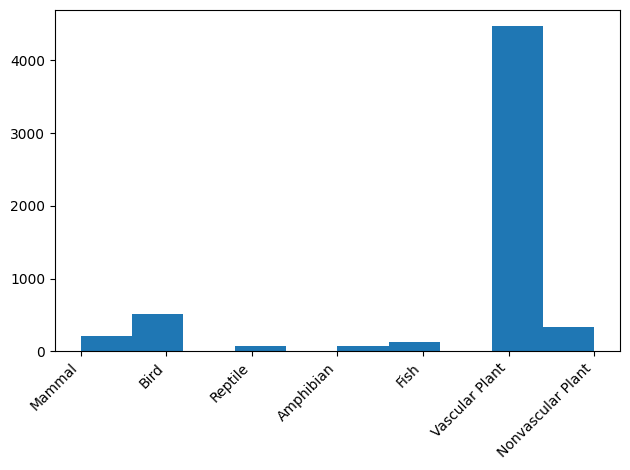

In [6]:
plt.hist(species.category)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()